# PDAC Calibration

Author: Sophie Wagner, sw3767@cumc.columbia.edu

In [ ]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# def create_matrix():
#     matrix = np.zeros((len(c.age_layers_1y), len(c.health_states_itos), len(c.health_states_itos)))
#     for (from_state, to_state), value in c.start_params.items()
#         if to_state == "u_PDAC_local":
#             ages, from_idx, to_idx, val = value
#             matrix[ages, from_idx, to_idx] = val
#         else:
#             from_idx, to_idx,z
#             matrix[:, from_idx, to_idx] = value

#     matrix = add_acm(matrix)  # ACM
#     matrix = add_csd(matrix)  # CSD
#     matrix = constrain_matrix(matrix)  # constrain
#     matrix = row_normalize(matrix)  # normalize


In [3]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        for row_idx in range(layer.shape[0]):  # Loop over each row
            row = layer[row_idx]
            row_sum = np.sum(row)  # Sum of all elements in the row
            
            if row_sum > 1:  # If the row probabilities exceed 1
                # Scale the entire row (except diagonal) to sum to 1
                row /= row_sum
            
            # Recalculate non-diagonal sum
            non_diag_sum = np.sum(row) - row[row_idx]
            
            # Adjust the diagonal element to ensure the row sums to 1
            row[row_idx] = max(0, 1 - non_diag_sum)
    
    return matrix


def create_matrix():
    matrix = np.zeros((len(c.age_layers_1y), len(c.health_states_itos), len(c.health_states_itos)))
    matrix[:, 0, 5] = 0.0002  # average risk
    matrix[:, 1, 5] = 0.009  # NOD period risk
    matrix[:, 2, 5] = np.linspace(0.009, 0.0011, 4)[1]  # gradual decrease
    matrix[:, 3, 5] = np.linspace(0.009, 0.0011, 4)[2]  # gradual decrease
    matrix[:, 4, 5] = 0.0011  # diabetic risk
    matrix[:, 5, 6] = (1-c.model_inputs_dict['p_symptom_local'])*c.model_inputs_dict['p_Local_to_Regional_PC']
    matrix[:, 6, 7] = (1-c.model_inputs_dict['p_symptom_regional'])*c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 5, 8] = c.model_inputs_dict['p_symptom_local']
    matrix[:, 6, 9] = c.model_inputs_dict['p_symptom_regional']
    matrix[:, 7, 10] = c.model_inputs_dict['p_symptom_distant']

    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    matrix = np.clip(matrix, 0.0, 1.0)

    # Progression Block
    avg, nod, dia = matrix[0, 0, 5], matrix[0, 1, 5], matrix[46, 4, 5]
    matrix[:, 1, 5] = np.maximum(avg, nod)
    matrix[:, 1, 5] = np.maximum(nod, dia)
    
    nod, dia = matrix[0, 1, 5], matrix[46, 4, 5]
    matrix[:, 2, 5] = np.linspace(nod, dia, 4)[1]
    matrix[:, 3, 5] = np.linspace(nod, dia, 4)[2]
    matrix[:, 5, 6] = np.maximum(matrix[:, 4, 5], matrix[:, 5, 6])
    matrix[:, 6, 7] = np.maximum(matrix[:, 5, 6], matrix[:, 6, 7])
    # Detection Block
    matrix[:, 6, 9] = np.maximum(matrix[:, 5, 8], matrix[:, 6, 9])
    matrix[:, 7, 10] = np.maximum(matrix[:, 6, 9], matrix[:, 7, 10])

    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])

    return matrix


def add_acm(matrix):
    matrix[:, :11, 12] = c.acm[:64, np.newaxis]  # Healthy to ACM
    matrix[:, 12, 12] = 1
    return matrix


def add_csd(matrix):
    matrix[:, 8, 11] = int(c.model_inputs_dict['p_local_death'])
    matrix[:, 9, 11] = int(c.model_inputs_dict['p_regional_death'])
    matrix[:, 10, 11] = int(c.model_inputs_dict['p_distant_death'])
    matrix[:, 11, 11] = 1
    return matrix

In [15]:
def step(matrix, step_size, num_adj=3):
    new_matrix = np.copy(matrix)
    step_mat = np.random.choice(len(c.transitions_itos), size=num_adj, replace=True)
    points = list(c.transitions_itos.keys()) 
    for i in range(num_adj):
        from_state, to_state = points[step_mat[i]]
        if 2 <= from_state <=3:
            continue
        else: 
            step_param = matrix[0, from_state, to_state] * step_size
            step_value = new_matrix[0, from_state, to_state] + np.random.uniform(low=-step_param, high=step_param)
            new_matrix[:, from_state, to_state] = step_value

    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_matrix

In [11]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (65, 13, 13)
    inflow_matrix = np.tril(matrixT, k=-1)
    old_risk, new_risk = 0, 1
    while current_age < max_age:
        
        # Check for diabetes risk change, transfer population
        if current_age in [60, 64, 65, 66]:
            # print(f"current_age: {current_age}")
            # print(f"month pop before: {month_pop}")
            # print(f"upcoming state transfers: {old_risk} to {new_risk}")
            month_pop_temp = month_pop.copy()
            month_pop[old_risk] = 0
            month_pop[new_risk] += month_pop_temp[old_risk]
            old_risk += 1
            new_risk += 1
            # print(f"transferred month pop: {month_pop}")
            # print(f"next state transfers: {old_risk} to {new_risk}")
            

        # Matrix multiplication (state transition)
        inflow_mat = inflow_matrix[age_layer]  # (13, 13)
        mat = matrixT[age_layer]
        month_inc = np.matmul(inflow_mat, month_pop)  # (13, 13)(13, 1) -> (13, 1)
        month_pop = np.matmul(mat, month_pop)  # (13, 13)(13, 1) -> (13, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        age_layer += 1

    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[8:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(13):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj

In [26]:
def objective(log):
    inc, _, _ = log
    score = 0
    
    loc_5y, reg_5y, dis_5y = [func.get_5y_means(inc[stage, ]) for stage in [8,9,10]]

    # Yearly incidence penalty (ages 20-84)
    score += np.square(loc_5y - c.seer_inc["LocalU"]).sum()
    score += np.square(reg_5y - c.seer_inc["RegionalU"]).sum()
    score += np.square(dis_5y - c.seer_inc["DistantU"]).sum()

    return score

In [27]:
def simulated_annealing(n_iterations, step_size, start_tmat=None, n_adj=7, verbose=False):

    if start_tmat is None:
        start_tmat = create_matrix()

    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = objective(best_log)  # evaluate the initial point
    curr_t, curr_eval = best_t, best_eval  # current working solution
    ticker = 0

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        
        for i in range(n_iterations):

            # Run model
            candidate_t = np.copy(curr_t)
            candidate_t = step(candidate_t, step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = objective(candidate_log)  # Evaluate candidate point

            # Update "best" if better than candidate
            if candidate_eval < best_eval:
                ticker = 0
                best_t, best_eval = np.copy(candidate_t), np.copy(candidate_eval)
                best_log = run_markov(best_t)

            else:
                ticker += 1

            # t = 10 / float(i+1)  # calculate temperature for current epoch
            t = 1 / (1 + np.log(i + 1))

            # Progress report
            if verbose and i % 1000 == 0:
                inc_log = best_log[2]
                total_dxd = np.sum(inc_log[6:9, :]) / c.N
                print(i, ": ", best_eval, "   CRC: ", round(total_dxd, 5),"   tick:",ticker)
                if i % 10000 == 0:
                    transition_probs = p.extract_transition_probs(best_t)
                    print(f"Progress report, i = {i}")
                    print(transition_probs)

            # Check if we should update "curr"
            diff = (candidate_eval - curr_eval)  # difference between candidate and current point evaluation
            metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
            if (diff < 0 or np.random.random() < metropolis):  # check if we should keep the new point
                curr_t, curr_eval = np.copy(candidate_t), np.copy(candidate_eval)  # store the new current point
                ticker = 0

            pbar.update(1)

    print(best_eval)
    
    return best_t

In [24]:
def run_sa(save_all=False):
    tmat = create_matrix()
    result = simulated_annealing(n_iterations=10000, step_size=0.01, start_tmat=tmat, n_adj=3, verbose=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc = curr_log

    # Extract transition probabilities
    transition_probs = p.extract_transition_probs(curr_tmat)

    # Saving
    if save_all:
        # Save the with the timestamp in the filenames
        output_dir = c.OUTPUT_PATHS[type]
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        transition_probs.to_csv(f"{log_path}/{timestamp}_tps.csv")
        plot_vs_seer(curr_log, c.seer_inc, save_imgs=True, outpath=plot_path, timestamp=timestamp)
        #p.plot_vs_seer_total(curr_log, c.seer_inc, save_imgs=True, outpath=plot_path, timestamp=timestamp)

    else:
        print(transition_probs)
        plot_vs_seer(log_adj, c.seer_inc)
        #p.plot_vs_seer_total(log_adj, c.seer_inc)

    return curr_tmat

Simulated annealing progress:   0%|          | 0/10000 [00:00<?, ?iteration/s]

C:\Users\sophi\AppData\Local\Temp\ipykernel_6340\3928338916.py:46: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
Simulated annealing progress:   0%|          | 6/10000 [00:00<02:57, 56.32iteration/s]

0 :  248731.58346917783    CRC:  0.09011    tick: 1
Progress report, i = 0
    From State    To State  Probability
0      healthy  u_PDAC_loc     0.000200
1          nod  u_PDAC_loc     0.009000
2  nod_to_dia1  u_PDAC_loc     0.006367
3  nod_to_dia2  u_PDAC_loc     0.003733
4          dia  u_PDAC_loc     0.001100
5   u_PDAC_loc  u_PDAC_reg     0.450000
6   u_PDAC_reg  u_PDAC_dis     0.450000
7   u_PDAC_loc  d_PDAC_loc     0.100000
8   u_PDAC_reg  d_PDAC_reg     0.380000
9   u_PDAC_dis  d_PDAC_dis     0.520000


Simulated annealing progress:  10%|█         | 1011/10000 [00:19<02:24, 62.05iteration/s]

1000 :  43835.53792736512    CRC:  0.04936    tick: 2


Simulated annealing progress:  20%|██        | 2010/10000 [00:36<01:54, 69.63iteration/s]

2000 :  10251.1223815012    CRC:  0.03185    tick: 1


Simulated annealing progress:  30%|███       | 3017/10000 [00:49<01:15, 92.96iteration/s]

3000 :  1994.3160636255557    CRC:  0.02184    tick: 0


Simulated annealing progress:  40%|████      | 4014/10000 [01:00<01:07, 88.64iteration/s] 

4000 :  487.56507616377235    CRC:  0.01908    tick: 0


Simulated annealing progress:  50%|█████     | 5013/10000 [01:13<01:17, 64.54iteration/s]

5000 :  285.10978192823205    CRC:  0.02211    tick: 2


Simulated annealing progress:  60%|██████    | 6019/10000 [01:24<00:42, 92.94iteration/s] 

6000 :  203.4373080773155    CRC:  0.02776    tick: 0


Simulated annealing progress:  70%|███████   | 7016/10000 [01:34<00:29, 99.71iteration/s] 

7000 :  153.21203334402043    CRC:  0.03461    tick: 0


Simulated annealing progress:  80%|████████  | 8015/10000 [01:46<00:28, 70.58iteration/s] 

8000 :  128.04427738356156    CRC:  0.03924    tick: 0


Simulated annealing progress:  90%|█████████ | 9013/10000 [02:00<00:10, 93.07iteration/s]

9000 :  108.9859542883286    CRC:  0.0431    tick: 1


Simulated annealing progress: 100%|██████████| 10000/10000 [02:12<00:00, 75.66iteration/s]


103.24272489692216
    From State    To State  Probability
0      healthy  u_PDAC_loc     0.000438
1          nod  u_PDAC_loc     0.001379
2  nod_to_dia1  u_PDAC_loc     0.001379
3  nod_to_dia2  u_PDAC_loc     0.001379
4          dia  u_PDAC_loc     0.001379
5   u_PDAC_loc  u_PDAC_reg     0.061642
6   u_PDAC_reg  u_PDAC_dis     0.061899
7   u_PDAC_loc  d_PDAC_loc     0.002547
8   u_PDAC_reg  d_PDAC_reg     0.010239
9   u_PDAC_dis  d_PDAC_dis     0.020829


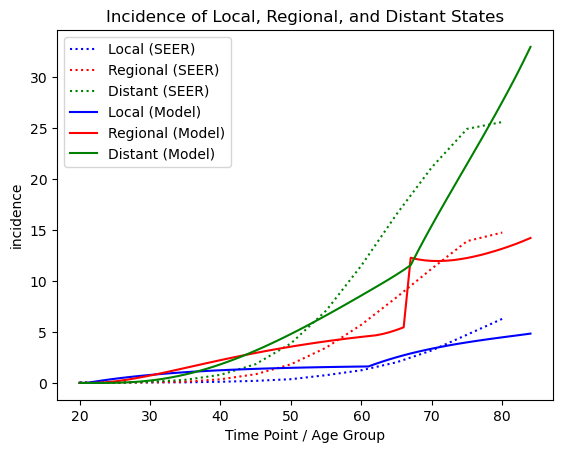

In [28]:
result=run_sa()

In [25]:
def plot_vs_seer(inc_adj, seer_inc, save_imgs=False, outpath=None, timestamp=None):
    """Plot model incidence by stage vs. SEER calibration incidence

    Args:
        inc_adj (matrix): output incidence log from run_markov
        seer_inc (df): item of comparison
    """
    x_values = np.arange(20, 85, 1)

    # Plot yearly incidence by stage
    plt.plot(seer_inc["Age"], seer_inc["LocalU"], label=f"Local (SEER)", color="b", linestyle="dotted")
    plt.plot(seer_inc["Age"], seer_inc["RegionalU"], label=f"Regional (SEER)", color="r", linestyle="dotted")
    plt.plot(seer_inc["Age"], seer_inc["DistantU"], label=f"Distant (SEER)", color="g", linestyle="dotted")
    plt.plot(x_values, inc_adj[8, :], label="Local (Model)", color="b")
    plt.plot(x_values, inc_adj[9, :], label="Regional (Model)", color="r")
    plt.plot(x_values, inc_adj[10, :], label="Distant (Model)", color="g")
    plt.legend()
    plt.title("Incidence of Local, Regional, and Distant States")
    plt.xlabel("Time Point / Age Group")
    plt.ylabel("incidence")
    if save_imgs:
        plt.savefig(f"{outpath}/{timestamp}_inc_stage.png")  # Save figure
        plt.close()
    else:
        plt.show()
